<a href="https://colab.research.google.com/github/prathamesh0902/STATS_630/blob/main/STATS_630_Hw_1_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)

1.13.1+cu116


# Creating Tensor Sparse matrix

##Importing Data, creating BOW

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#importing the data sets
train = pd.read_csv("/content/drive/MyDrive/Data_Files/si630w23-hw1.train.csv")
validation = pd.read_csv("/content/drive/MyDrive/Data_Files/si630w23-hw1.dev.csv")
test = pd.read_csv("/content/drive/MyDrive/Data_Files/si630w23-hw1.test.csv")

In [4]:
#splitting the data into input and output values
X_train, y_train = train['text'].values, train['sarcastic'].values
X_val, y_val = validation['text'].values, validation['sarcastic'].values
X_test = test['text'].values

In [5]:
#Making count of words in all the data set
words_count = {}

for words in X_train:
    for word in words.split(" "):
        if word in words_count:
            words_count[word] += 1
        else:
            words_count[word] = 1

In [6]:
words_counts = {i:words_count[i] for i in words_count if i!=0 }

In [7]:
#Converting input data into a vector: bag of words
DICT_SIZE = 5000
WORDS_TO_INDEX = {j[0]:i for i,j in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}####### YOUR CODE HERE #######
INDEX_TO_WORDS = {i:j[0] for i,j in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}####### YOUR CODE HERE #######
ALL_WORDS = WORDS_TO_INDEX.keys()

def tokenize(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    new_key= [words_to_index[i] for i in text.split(" ") if i in words_to_index.keys()]
    result_vector[new_key]=1
    return result_vector

##Conversion to sparse matrix

In [8]:
from scipy import sparse as sp_sparse
import tensorflow as tf

In [9]:
#conversion to sparse matrix
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(tokenize(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(tokenize(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(tokenize(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (3467, 5000)
X_val shape  (280, 5000)
X_test shape  (1400, 5000)


In [10]:
def to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [11]:
X_train_sparse =  to_sparse_tensor(X_train_mybag)
X_val_sparse =  to_sparse_tensor(X_val_mybag)
X_test_sparse =  to_sparse_tensor(X_test_mybag)

In [12]:
X_train_dense = tf.sparse.to_dense(X_train_sparse).numpy()
X_val_dense = tf.sparse.to_dense(X_val_sparse).numpy()
X_test_dense = tf.sparse.to_dense(X_test_sparse).numpy()

In [13]:
X_train_tensor  = torch.Tensor(X_train_dense)
X_val_tensor = torch.Tensor(X_val_dense)
X_test_tensor = torch.Tensor(X_test_dense)

In [14]:
y_train_tensor = torch.Tensor(y_train)
y_val_tensor = torch.Tensor(y_val) #tf.convert_to_tensor(y_val)

#Setting up Neural Network

## More Libraries

In [15]:
import os
import torch.optim as optim #Stochastic grad, Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F #relu, tanh

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [17]:
input_dim = 5000  # 28 * 28 images
output_dim =  1
learning_rate = 0.001
batch_size = 64
epochs = 1000000

In [18]:
#train_dataset = datasets.MNIST(root = 'dataset/', train = True, transform = transforms.ToTensor(), download = True)
train_loader = DataLoader(dataset = X_train_tensor, batch_size= batch_size, shuffle = True)

## Training starts

In [19]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear = nn.Linear(input_dim, output_dim)
        print('linear',self.linear.weight.dtype)

    def forward(self,x):
        #x = self.flatten(x)
        outputs = torch.sigmoid(self.linear(x))
        return outputs


https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be


In [20]:
model = LogisticRegression(input_dim, output_dim) #.to(device)

linear torch.float32


In [21]:
criterion = nn.BCELoss()   #loss
optimizer = torch.optim.SGD(model.parameters(), lr =learning_rate)  #grad

In [22]:
losses = []
losses_test = []
Iterations = []
iter = 0

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(torch.squeeze(outputs), y_train_tensor)
    loss.backward()
    optimizer.step()

    iter+=1
    if iter%10==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(X_val_tensor))
            loss_test = criterion(outputs_test, y_val_tensor)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_val_tensor.size(0)
            correct_test += np.sum(predicted_test == y_val_tensor.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train_tensor.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train_tensor.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            #print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            #print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

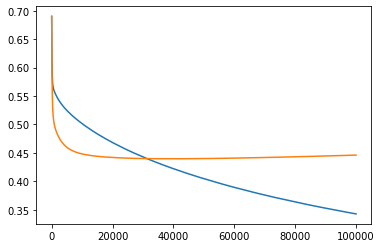

In [23]:
_= plt.plot(losses)
_= plt.plot(losses_test)



```
for batch_idx, data in enumerate(train_loader):
        data = data.to(torch.float32)
        data = data.to(device = device)
        targets = y_train_tensor.to(torch.float32)
        targets = targets.to(device = device)
        print('x.dtype ',data.dtype )
        #Flatten
        #data = data.reshape(data.shape[0], -1)

        #Forward
        scores = model(data)
        print('scores ',scores.dtype )
        print('targets ',targets.dtype )
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step() 
        _= ''''''
```



In [24]:
_ = '''def training_not_woring3():
  class NeuralNetwork(nn.Module):
      def __init__(self):
          super(NeuralNetwork, self).__init__()
          self.flatten = nn.Flatten()
          self.linear_relu_stack = nn.Sequential(
              nn.Linear(28*28, 512),
              nn.ReLU(),
              nn.Linear(512, 512),
              nn.ReLU(),
              nn.Linear(512, 10),
          )

      def forward(self, x):
          x = self.flatten(x)
          logits = self.linear_relu_stack(x)
          return logits

      def backward(self, input):
          output = my_function(input, self.parameters) # here you call the function!
          return output'''